In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

train = pd.DataFrame({
    'target': train.iloc[:, 0],  # first column is the label
    'digits': train.iloc[:, 1:].values.tolist()  # rest of the columns are the image data
})

test = pd.DataFrame({
    'digits': test.iloc[:, :].values.tolist()  # rest of the columns are the image data
})


In [3]:
test.iloc[0]

digits    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

This is big

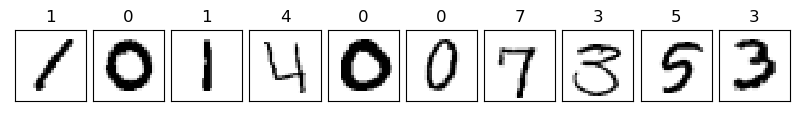

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    img = np.array(train.digits.iloc[i]).reshape(28, 28)  # get image data and reshape to 2D array
    ax.set_title(train.target.iloc[i])
    ax.imshow(img, cmap='binary', interpolation='nearest', clim=(0, 255))    

In [5]:
np.array(train.digits.to_list()).shape

(42000, 784)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(10)
projected = pca.fit_transform(np.array(train.digits.to_list())) 
print(np.array(train.digits.to_list()).shape)
print(projected.shape)

(42000, 784)
(42000, 10)


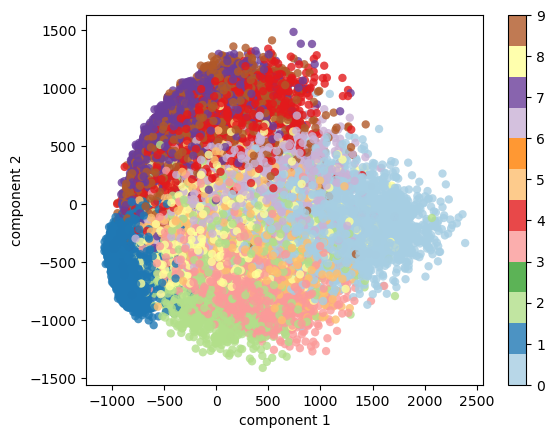

In [7]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(train.target.to_list()), edgecolor='none', alpha=0.8,
            cmap='Paired')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

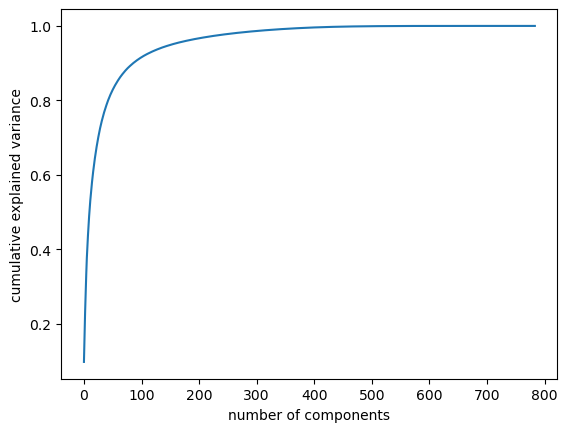

In [8]:
pca = PCA().fit(np.array(train.digits.to_list()))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
print("Explained variance in the first component:", pca.explained_variance_ratio_[0])
print("Explained variance in the first 100 components", sum(pca.explained_variance_ratio_[:100]))

Explained variance in the first component: 0.09748937689497449
Explained variance in the first 100 components 0.9150393160310483


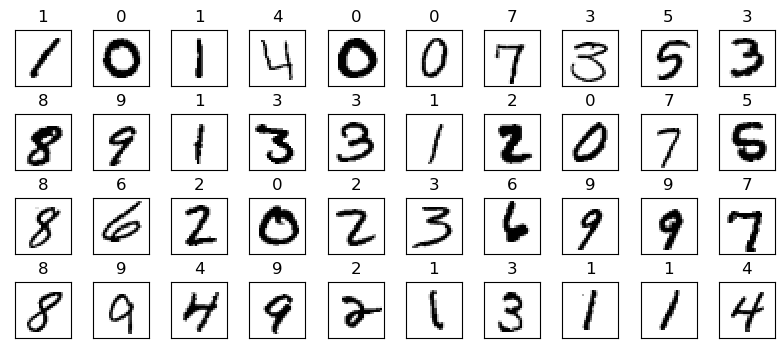

In [10]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.5, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img = np.array(train.digits.iloc[i]).reshape(28, 28)  # get image data and reshape to 2D array
        ax.set_title(train.target.iloc[i])
        ax.imshow(img, cmap='binary', interpolation='nearest', clim=(0, 255))    
plot_digits(np.array(train.digits.to_list()))

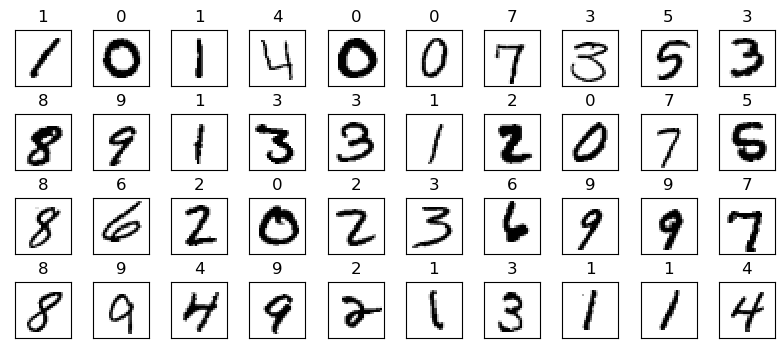

In [11]:
pca = PCA(2).fit(np.array(train.digits.to_list()))
components = pca.transform(np.array(train.digits.to_list()))
components_2 = pca.inverse_transform(components)
plot_digits(components_2)

In [12]:
def plot_digits_a_little_bit(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.5, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img = np.array(train.digits.iloc[i]).reshape(28, 28)[8:16,8:16]  # get image data and reshape to 2D array
        ax.set_title(train.target.iloc[i])
        ax.imshow(img, cmap='binary', interpolation='nearest', clim=(0, 255))    

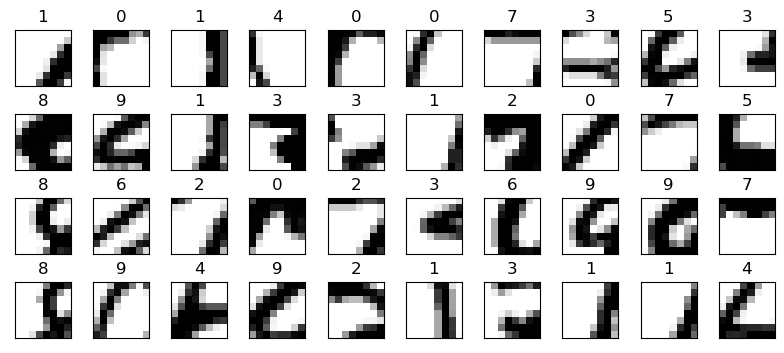

In [13]:
plot_digits_a_little_bit(np.array(train.digits.to_list()))

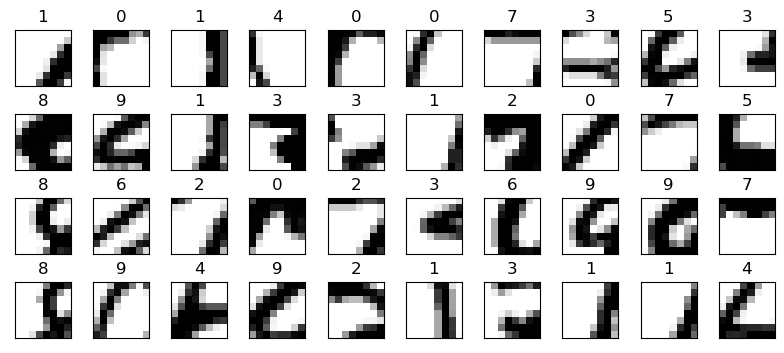

In [14]:
plot_digits_a_little_bit(components_2)

In [15]:
X_train = pd.DataFrame(train.digits.apply(lambda x: {i: x[i] for i in range(len(x))}).tolist())
y_train = train.target
#X_test = pd.DataFrame(test.digits.apply(lambda x: {i: x[i] for i in range(len(x))}).tolist())
#y_test = test.target
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [16]:
from sklearn.model_selection import train_test_split
random_state = 12
X_train, X_test, y_train, y_test = \
    train_test_split(X_train, y_train, 
                     test_size=0.3,
                     shuffle=True, 
                     random_state=random_state)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# X_train, X_test, y_train, y_test = X_train[:100], X_test[:10], y_train[:100], y_test[:10]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29400, 784) (12600, 784) (29400,) (12600,)
(29400, 784) (12600, 784) (29400,) (12600,)


In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
components = 100
_sc = StandardScaler()
_pca = PCA(n_components=components)
_model = LogisticRegression(max_iter=1000)
log_regress_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('regressor', _model)
])

log_regress_model.fit(X_train,y_train)
log_regress_model.score(X_test,y_test)

(29400, 784) (12600, 784) (29400,) (12600,)


0.9153968253968254

In [19]:
X_test.shape

(12600, 784)

In [20]:
results = log_regress_model.predict(np.array(test.digits.to_list()))
results = pd.DataFrame({"Label": results})
results['ImageId'] = results.reset_index().index + 1
results = results[["ImageId", "Label"]]

In [21]:
results.to_csv('/kaggle/working/submission.csv', index=False)

In [22]:
pd.read_csv('/kaggle/working/submission.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [23]:
pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0
